In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add project 1 to sys path 
import sys
sys.path.append('../project1/')
import tools as proj1_tools
import project2_tools as proj2_tools

import numpy as np
import matplotlib.pyplot as plt

In [2]:
L = 40
temps = proj2_tools.get_available_t()
states = proj2_tools.read_t(temps[0])
#states.shape

##### Plot configurations for some temperatures

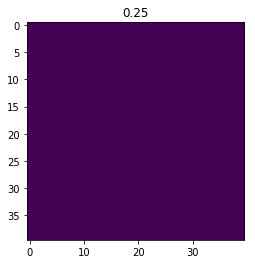

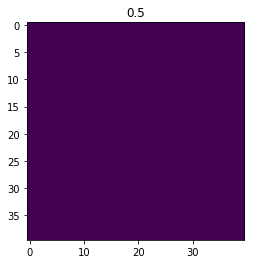

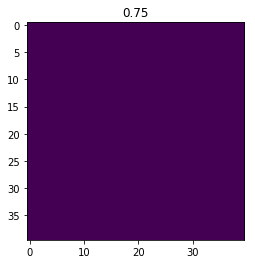

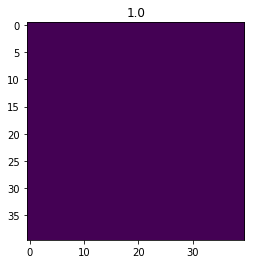

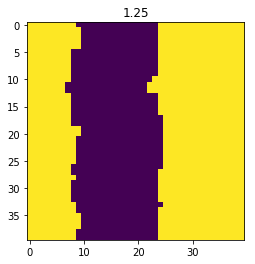

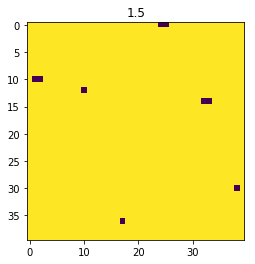

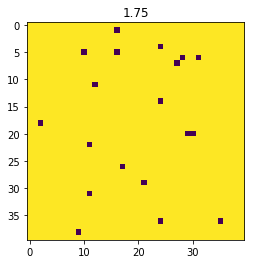

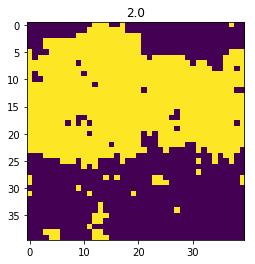

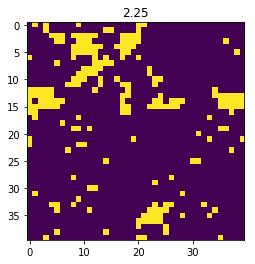

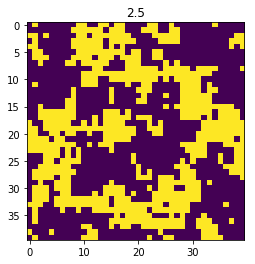

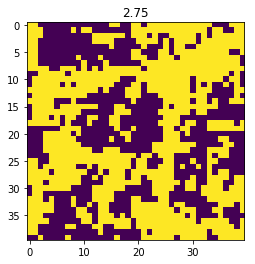

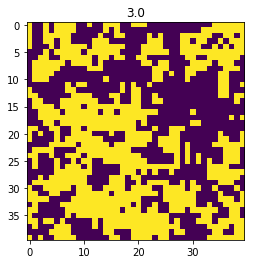

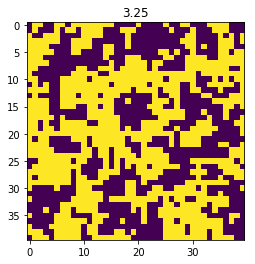

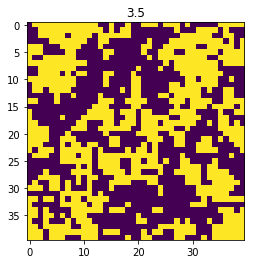

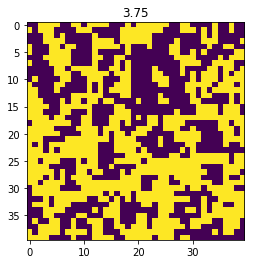

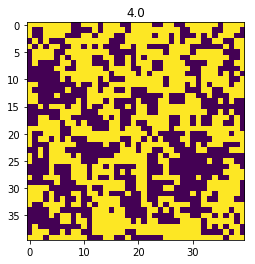

In [3]:
#print(temps)
t_crit = 2.3
for t_low in temps:
    
    label = int(t_crit > t_low)
    
    plt.figure()
    states_low_t = proj2_tools.read_t(t_low)
    plt.imshow(states_low_t[1].reshape(L,L))
    plt.title(t_low)

# Two dimensional Ising Model 

Make training data

In [4]:
def get_train_data(n, L):
    """Pick some random training data from whole data set"""
    Nt = temps.size
    Nl = L * L
    data = np.zeros((Nt, n, Nl),dtype=np.int8)
    for i,t in enumerate(temps):
        d = proj2_tools.read_t(t)
        d[np.where(d == 0)] = -1
        data[i] = d
        
    n_ordered = np.sum(temps > t_crit)
    classes = np.zeros((Nt,n),dtype = np.int8)
    classes[:-n_ordered] = 1
    
    data = data.reshape(-1, Nl)
    
    classes = classes.ravel()
    return data, classes

    
n = 10000
L = 40
data,classes = get_train_data(n, L)

In [44]:
N_train = 1000

np.random.seed(0)
indx = np.arange(data.shape[0])
np.random.shuffle(indx)

X_train = data[indx][:N_train]
X_train = np.c_[np.ones_like(X_train[:,0]), X_train]
y_train = classes[indx][:N_train]

X_test = data[indx][N_train:2*N_train]
X_test = np.c_[np.ones_like(X_test[:,0]), X_test]
y_test = classes[indx][N_train:2*N_train]

X_test2 = data[indx][2*N_train:3*N_train]
X_test2 = np.c_[np.ones_like(X_test2[:,0]), X_test2]
y_test2 = classes[indx][2*N_train:3*N_train]

X_test3 = data[indx][3*N_train:4*N_train]
X_test3 = np.c_[np.ones_like(X_test3[:,0]), X_test3]
y_test3 = classes[indx][3*N_train:4*N_train]


Nd = 2
Np = X.shape[1]

# Newton raphson

In [ ]:
gamma = 1e-4
beta = 2e-6*(np.random.random(size = (Np,Nd-1)) - 0.5).squeeze()

for i in range(10):
    a = (X @ beta).T
    p0  =  1/ (1 + np.exp(a)).squeeze()
    p1 = 1 - p0 #(np.exp(a)*p0).squeeze()
    
    p = np.choose(y, [p0, p1])
    
    
    Wii = np.diag(p*(1-p))
    hess = (X.T @ Wii) @ X
    deriv_cost = - X.T @ (y - p)
    
    dbeta = - np.linalg.inv(hess) @ deriv_cost
    beta = beta + gamma*dbeta
    
    correct = p > 0.5
    print(np.mean(correct))

# Gradient descent

36


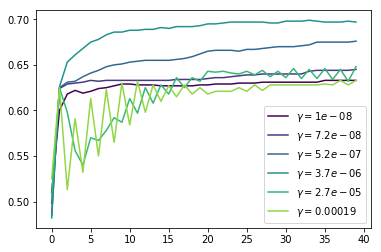

In [14]:
niter = 40
ngamma = 36


gamma_values = np.logspace(-8,-3,ngamma)
value = np.zeros((niter,ngamma))

colors = plt.cm.viridis(np.linspace(0,1,ngamma+1)[:-1])
print(len(colors))
for j,gamma in enumerate(gamma_values):
    beta = 1e-6*(np.random.random(size = (Np,Nd-1)) - 0.5).squeeze()
    for i in range(niter):
        #gamma = gamma_values[j]
        a = (X @ beta).T
        p0  =  1/ (1 + np.exp(a)).squeeze()
        p1 = (np.exp(a)*p0).squeeze()
        p = np.choose(y,[p0, p1])

        deriv_cost = - X.T @ (y - p)
        beta = beta - gamma * deriv_cost 

        correct = p > 0.5
        value[i,j] = np.mean(correct)
        
    if j%6 == 0 :
        plt.plot(value[:,j], c = colors[j], label='$\gamma = {:.2g}$'.format(gamma))
plt.legend()
plt.show()
    

In [12]:
plt.semilogx(gamma_values, value[-1],)

# Logistic regression
##### Compared with $sklearn.linear\_model.LogisticRegression$

In [7]:
import logreg
from sklearn.linear_model import LogisticRegression

Prepare test sets:

In [174]:
Xtestset = [X_test,X_test2,X_test3]
ytestset = [y_test,y_test2,y_test3]

#### Train/Test of our model

In [171]:
regr = logreg.Logistic_Regression(learn_rate=0.1, iterations=1000, normalize=False, lmbd=1)
regr.fit(X_train,y_train)

Statistics:

In [184]:
# Train
z_train = regr.predict(X_train,binary=False)
acc_train1 = regr.accuracy(y_train,z_train)
mse_train1 = np.sum(np.abs(z_train-y_train)**2)/y_train.shape[0]
# Test
acc_test1 = []
mse_test1 = []
for i,test in enumerate(Xtestset):
    z_test = regr.predict(test,binary=False)
    acc_test1.append(regr.accuracy(ytestset[i],z_test))
    mse_test1.append(np.sum(np.abs(ytestset[i]-z_test)**2)/ytestset[i].shape[0])

#### Train/Test of sklearn model:

In [204]:
Lregr = LogisticRegression(C=1.0/1,random_state=1,verbose=0,max_iter=1E3,tol=1E-5, solver='lbfgs')
Lregr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000.0, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
          tol=1e-05, verbose=0, warm_start=False)

Statistics:

In [208]:
# Train
L_z_train = Lregr.predict(X_train)
acc_train2 = regr.accuracy(y_train,L_z_train)
mse_train2 = np.sum(np.abs(L_z_train-y_train)**2)/y_train.shape[0]

# Test
acc_test2 = []
mse_test2 = []
for i,test in enumerate(Xtestset):
    L_z_test = Lregr.predict(test)
    acc_test2.append(Lregr.score(test,ytestset[i]))
    mse_test2.append(np.sum(np.abs(ytestset[i]-L_z_test)**2)/ytestset[i].shape[0])

#### Compare

In [209]:
print('   {:<10}{:<15}{:<15}'.format('','Our model', 'sklearn model'))
print('\nTraining set:\n')
print('   {:<10}{:<15}{:<15}'.format('Accuracy',acc_train1,acc_train2))
print('   {:<10}{:<15}{:<15}'.format('MSE',mse_train1,mse_train2))
for i in range(len(acc_test1)):
    print('\nTest set ',i+1,':\n')
    #print('{:<10}{:<15}{:<15}'.format('','Our model', 'sklearn model'))
    print('   {:<10}{:<15}{:<15}'.format('Accuracy',acc_test1[i],acc_test2[i]))
    print('   {:<10}{:<15}{:<15}'.format('MSE',mse_test1[i],mse_test2[i]))

             Our model      sklearn model  

Training set:

   Accuracy  0.972          1.0            
   MSE       0.028          0.0            

Test set  1 :

   Accuracy  0.672          0.671          
   MSE       0.328          0.329          

Test set  2 :

   Accuracy  0.675          0.668          
   MSE       0.325          0.332          

Test set  3 :

   Accuracy  0.686          0.664          
   MSE       0.314          0.336          


#### Best learn rate

In [120]:
##BEST learn_rate:
lmbds = np.logspace(-5,0,6)
for i,lmbd in enumerate(lmbds):
    #print('Learning rate = ',lr,':')
    print('Lambda = ',lmbd,':')
    regr = logreg.Logistic_Regression(learn_rate=0.1, iterations=1000, normalize=False,lmbd=lmbd)
    regr.fit(X_train,y_train)
    z_train = regr.predict(X_train,binary=False)
    print('Train Accuracy: ',regr.accuracy(y_train,z_train))
    print('Train Squared error: ', np.sum(np.abs(z_train-y_train)**2)/y_train.shape[0])
    z_test = regr.predict(X_test,binary=False)
    print('Test Accuracy: ',regr.accuracy(y_test,z_test))
    print('Test Squared error: ', np.sum(np.abs(z_test-y_test)**2)/y_test.shape[0])


Lambda =  1e-05 :
Train Accuracy:  0.994
Train Squared error:  2.522334468758256e-12
Test Accuracy:  0.627
Test Squared error:  0.3720000034986225
Lambda =  0.0001 :
Train Accuracy:  0.996
Train Squared error:  5.7843768008704014e-12
Test Accuracy:  0.628
Test Squared error:  0.372
Lambda =  0.001 :
Train Accuracy:  0.996
Train Squared error:  5.907011384808941e-13
Test Accuracy:  0.629
Test Squared error:  0.371
Lambda =  0.01 :
Train Accuracy:  0.995
Train Squared error:  1.7406975531894687e-15
Test Accuracy:  0.633
Test Squared error:  0.367
Lambda =  0.1 :
Train Accuracy:  1.0
Train Squared error:  0.0
Test Accuracy:  0.648
Test Squared error:  0.352
Lambda =  1.0 :
Train Accuracy:  0.972
Train Squared error:  0.028
Test Accuracy:  0.672
Test Squared error:  0.328
Lambda =  10.0 :
Train Accuracy:  0.907
Train Squared error:  0.093
Test Accuracy:  0.661
Test Squared error:  0.339
Lambda =  100.0 :


/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project2/logreg.py:19: RuntimeWarning: overflow encountered in multiply
  self.beta -= self.learn_rate * grad


Train Accuracy:  0.0
Train Squared error:  nan
Test Accuracy:  0.0
Test Squared error:  nan


=> best learning rate = 0.1 

In [107]:
from sklearn.linear_model import LogisticRegression

In [148]:
Lregr = LogisticRegression(fit_intercept=False, max_iter=1000, solver='lbfgs', penalty='l2',multi_class='multinomial')
Lregr.fit(X_train,y_train)
Lz_test = Lregr.predict(X_train)

In [149]:
Lz_test = Lregr.predict(X_test)
regr.accuracy(Lz_test,y_test)

0.67

#### Train model

In [125]:
regr = logreg.Logistic_Regression(learn_rate=0.1, iterations=100, normalize=False)
regr.fit(X_train,y_train)
z_train = regr.predict(X_train,binary=False)
print('Accuracy: ',regr.accuracy(y_train,z_train))
print('Squared error: ', np.sum(np.abs(z_train-y_train)**2)/y_train.shape[0])

Accuracy:  0.629
Squared error:  0.34515193292504953


##### Test model

In [124]:
z_test = regr.predict(X_test,binary=False)
print('Accuracy: ',regr.accuracy(y_test,z_test))
print('Squared error: ', np.sum(np.abs(z_test-y_test)**2)/y_test.shape[0])

Accuracy:  0.379
Squared error:  0.6189692568859007


In [116]:
z_test2 = regr.predict(X_test2,binary=False)
print('Accuracy: ',regr.accuracy(y_test2,z_test2))
print('Squared error: ', np.sum(np.abs(z_test2-y_test2)**2)/y_test2.shape[0])

Accuracy:  0.471
Squared error:  0.529


In [117]:
z_test3 = regr.predict(X_test3,binary=False)
print('Accuracy: ',regr.accuracy(y_test3,z_test3))
print('Squared error: ', np.sum(np.abs(z_test3-y_test3)**2)/y_test3.shape[0])

Accuracy:  0.498
Squared error:  0.502
